In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

In [2]:
df = pd.read_csv('datasets/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

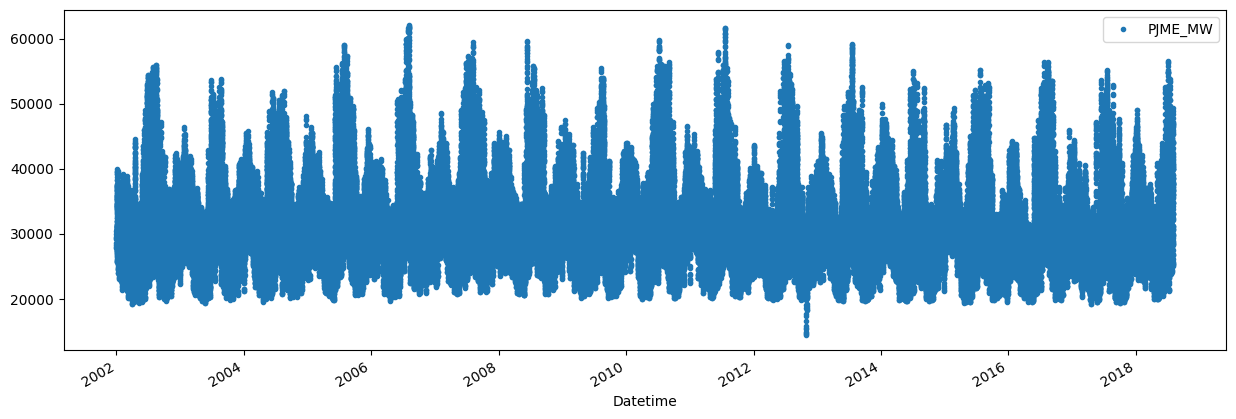

In [3]:
df.plot(style='.', figsize=(15, 5))
plt.show()

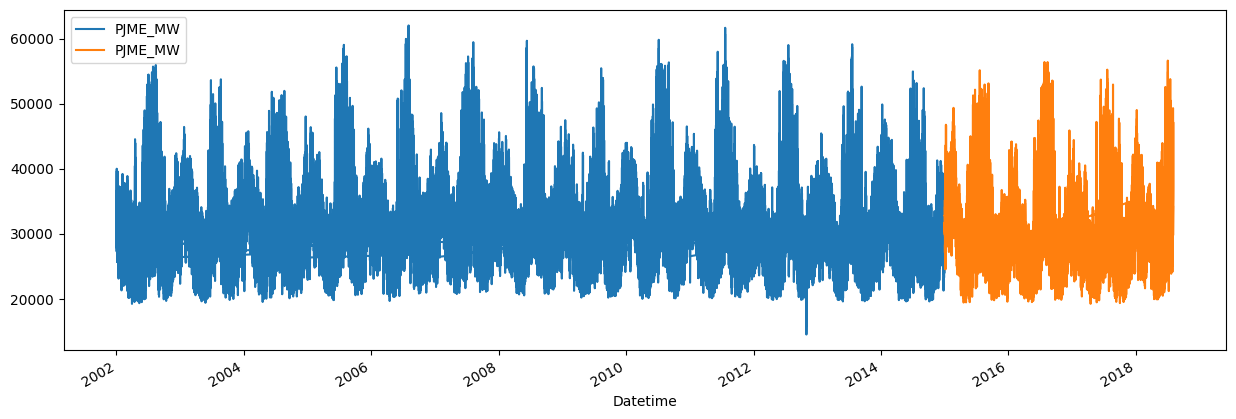

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Testing set')

plt.show()

In [5]:
def create_features(dataframe):
    df = dataframe.copy()

    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.day_of_year

    return df

In [6]:
train = create_features(train)
test = create_features(test)

## Create the model

In [7]:
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']
target = [train.columns[0]]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature importance

In [8]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

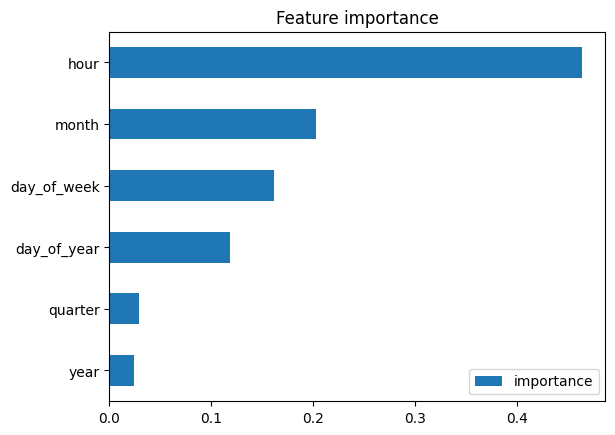

In [9]:
fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()

We can see that the most important feature is 'hour'.

In [10]:
df = create_features(df)

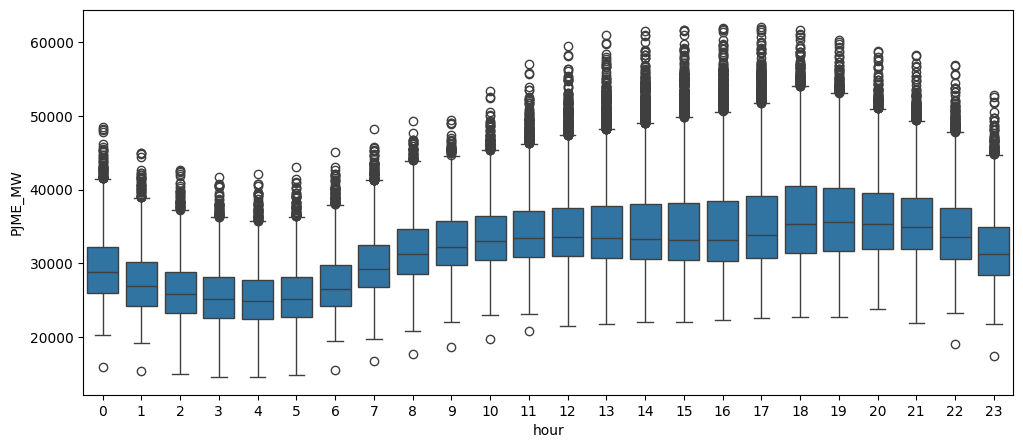

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
plt.show()

People use electricity the least at 4 AM and the most at 6 PM. The amount of electricity used from 9 AM to 10 PM is fairly the same.

## Forecast on test set

In [12]:
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

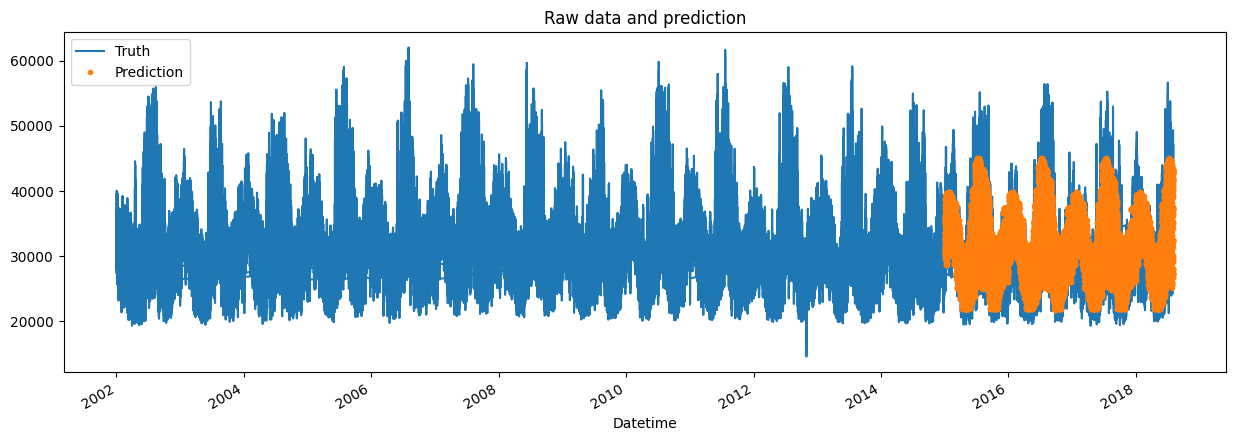

In [13]:
ax = df[target].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth', 'Prediction'])
ax.set_title('Raw data and prediction')

plt.show()

### Evaluation

In [14]:
score = root_mean_squared_error(test['PJME_MW'], test['prediction'])
print(f'RMSE score on test set: {score:0.2f}')

RMSE score on test set: 3741.03


Look at the worst and the best predicted days

In [17]:
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64